In [37]:
import pandas as pd
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow import  keras
from tensorflow.keras import layers, models

In [38]:
df =pd.read_csv("dataset_file_directory.csv")


In [39]:
p1_dataset =df[df['Participant']== 'P01']
p1_datasets =p1_dataset[~p1_dataset['Label'].isin([ 'dysregulation-bathroom','bathroom','glee'])]

In [40]:
classess=p1_datasets['Label'].value_counts()

In [41]:
classess

selftalk              564
delighted             357
dysregulated          212
social                182
frustrated            150
request               130
dysregulation-sick     74
Name: Label, dtype: int64

In [42]:
p1_datasets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1669 entries, 0 to 1707
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Filename     1669 non-null   object
 1   Participant  1669 non-null   object
 2   Label        1669 non-null   object
dtypes: object(3)
memory usage: 52.2+ KB


In [43]:
# Specify the directory where your Python script is located
script_dir = r"C:\Users\pawan\Desktop\mv\downloaddataset"
# Define the relative path to the WAV files directory
wav_dir = os.path.join(script_dir, "downloaded_wav_files")

In [44]:
def extract_audio_features(dataset):
    null_file = 0
    
    for index, row in dataset.iterrows():
        filename = row['Filename']
        participant = row['Participant']
        label = row['Label']
        wav_file_path = os.path.join(wav_dir, filename)

        # Check if the audio file exists before attempting to load it
        if os.path.exists(wav_file_path):
            try:
                # Load the WAV file using librosa
                audio_data, sample_rate = librosa.load(wav_file_path, sr=None) 
                # Perform feature extraction (e.g., MFCCs)
                mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=50)
                chroma = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)
                spectral_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sample_rate)
                mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_mels=13)
                stft = librosa.stft(audio_data)
                fft_features = np.abs(stft)
                rmse = librosa.feature.rms(y=audio_data)
                
                fft_features_db = librosa.amplitude_to_db(fft_features, ref=np.max)

            # Calculate the mean of FFT features
                fft_features_mean = np.mean(fft_features_db, axis=1)
                rmse_mean = np.mean(rmse)
                mfccs_mean = np.mean(mfccs, axis=1)
                chroma_mean = np.mean(chroma, axis=1)
                spectral_contrast_mean = np.mean(spectral_contrast, axis=1)
                mel_spectrogram_mean = np.mean(mel_spectrogram, axis=1)
                
                # Combine the extracted features into a single vector
                combined_mmcs=np.hstack((mfccs_mean,mel_spectrogram_mean,chroma_mean,spectral_contrast_mean))
                combined_feature_vector = np.hstack((mfccs_mean, chroma_mean, spectral_contrast_mean, mel_spectrogram_mean, fft_features_mean, rmse_mean))
                mf_mel=np.hstack((mfccs_mean,mel_spectrogram_mean))
                mf_co=np.hstack((mfccs_mean,chroma_mean))
                mf_ch=np.hstack((mfccs_mean,spectral_contrast_mean))
                # Append the extracted features and label to the lists
                mf_ch_list.append(mf_mel)
                mf_co_list.append(mf_ch)
                mf_mel_list.append(mf_co)
                mfcc_fe.append(mfccs_mean)
                rmse_fe.append(rmse_mean)
                chroma_fe.append(chroma_mean)
                spectral_constrast_fe.append(spectral_contrast_mean)
                mel_spectrogram_fe.append(mel_spectrogram_mean)
                fft_fe.append(fft_features_mean)
                combined_4.append(combined_mmcs)
                combined_fe.append(combined_feature_vector)
                labels_list.append(label)

            except Exception as e:
                print(f"Error processing {wav_file_path}: {str(e)}")
        else:
            null_file += 1
            print(f"Audio file not found: {wav_file_path}")

    print("Related audio files not found count:", null_file)

    return null_file


In [45]:
mfcc_fe=[]
rmse_fe=[]
chroma_fe=[]
spectral_constrast_fe=[]
mel_spectrogram_fe=[]
fft_fe=[]

#fusion of mfcc+mel,fusion of mfcc + contrast,mfcc+chroma
mf_ch_list=[]
mf_co_list=[]
mf_mel_list=[]
combined_4=[]
labels_list=[]
combined_fe=[]
extract_audio_features(p1_datasets)


Related audio files not found count: 0


0

In [47]:
X_mfcc_fe  = np.array(mfcc_fe)
X_rmse_fe  = np.array(rmse_fe)
X_chroma_fe  = np.array(chroma_fe)
X_spectral_constrast_fe= np.array(spectral_constrast_fe)
X_mel_spectrogram_fe= np.array(mel_spectrogram_fe)
X_fft_fe= np.array(fft_fe)

X_mf_ch=np.array(mf_ch_list)
X_mf_co=np.array(mf_co_list)
X_mf_mel=np.array(mf_mel_list)
X_combined=np.array(combined_4)

y=np.array(labels_list)

In [48]:
X_mel_spectrogram_fe.shape

(1669, 13)

In [49]:
# Encode the labels
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


X_train_mfccs, X_test_mfccs, y_train1, y_test1 = train_test_split(X_mfcc_fe, y_encoded, test_size=0.2, random_state=42)
X_train_chroma, X_test_chroma, _, _ = train_test_split(X_chroma_fe, y_encoded, test_size=0.2, random_state=42)
X_train_spectral_contrast, X_test_spectral_contrast, _, _ = train_test_split(X_spectral_constrast_fe, y_encoded, test_size=0.2, random_state=42)
X_train_mel_spectrogram, X_test_mel_spectrogram, _, _ = train_test_split(X_mel_spectrogram_fe, y_encoded, test_size=0.2, random_state=42)
X_train_fft, X_test_fft, _, _ = train_test_split(X_fft_fe, y_encoded, test_size=0.2, random_state=42)
X_train_rmse, X_test_rmse, _, _ = train_test_split(X_rmse_fe, y_encoded, test_size=0.2, random_state=42)

X_mf_ch_train, X_mf_ch_test, _,_ = train_test_split(X_mf_ch, y_encoded, test_size=0.2, random_state=42)
X_mf_co_train, X_mf_co_test, _, _ = train_test_split(X_mf_co, y_encoded, test_size=0.2, random_state=42)
X_mf_mel_train, X_mf_mel_test, _, _ = train_test_split(X_mf_mel, y_encoded, test_size=0.2, random_state=42)
X_combined_train, X_combined_test, _, _ = train_test_split(X_combined, y_encoded, test_size=0.2, random_state=42)



In [50]:
print(p1_datasets['Label'].nunique())

7


In [51]:
import tensorflow as tf
from tensorflow.keras import layers, models
def cnn_model(X_train,y_train,X_test,y_test):
    n_classes=p1_datasets['Label'].nunique()
    model = models.Sequential([
        layers.Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
    
        # Add more convolutional layers
        layers.Conv1D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
    
        layers.Conv1D(128, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
    
        layers.Conv1D(256, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
    
        layers.Flatten(),
    
        # Add more dense layers
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),  # Dropout layer to reduce overfitting
    
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
    
        layers.Dense(n_classes, activation='softmax') 
    ])
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=50, 
                   validation_split=0.2, 
                    batch_size=45)
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    accuracy_stack.append(test_accuracy)
    print(f"Test accuracy: {test_accuracy}")
    
    return model


def create_cnn_model(input_shape, num_classes):
    model = keras.Sequential([
        layers.Reshape((input_shape, 1), input_shape=(input_shape, )),  # Reshape for 1D convolution

        # Convolutional layers
        layers.Conv1D(64, 3, activation='relu', padding='same'),
        layers.Conv1D(128, 3, activation='relu', padding='same'),
        layers.Conv1D(256, 3, activation='relu', padding='same'),

        # Flatten layer
        layers.Flatten(),

        # Fully connected layers
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),

        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [52]:
accuracy_stack=[]

In [53]:

model_mfcc=cnn_model(X_train_mfccs,y_train1,X_test_mfccs,y_test1)

Epoch 1/50
24/24 [==============================] - 1s 26ms/step - loss: 2.8841 - accuracy: 0.2331 - val_loss: 1.6886 - val_accuracy: 0.3483
Epoch 2/50
24/24 [==============================] - 0s 13ms/step - loss: 1.7943 - accuracy: 0.2903 - val_loss: 1.7385 - val_accuracy: 0.3483
Epoch 3/50
24/24 [==============================] - 0s 12ms/step - loss: 1.7769 - accuracy: 0.2987 - val_loss: 1.6688 - val_accuracy: 0.3483
Epoch 4/50
24/24 [==============================] - 0s 13ms/step - loss: 1.6900 - accuracy: 0.3193 - val_loss: 1.6203 - val_accuracy: 0.3371
Epoch 5/50
24/24 [==============================] - 0s 12ms/step - loss: 1.6794 - accuracy: 0.3240 - val_loss: 1.6142 - val_accuracy: 0.3408
Epoch 6/50
24/24 [==============================] - 0s 13ms/step - loss: 1.6090 - accuracy: 0.3502 - val_loss: 1.5426 - val_accuracy: 0.3933
Epoch 7/50
24/24 [==============================] - 0s 13ms/step - loss: 1.6089 - accuracy: 0.3680 - val_loss: 1.4998 - val_accuracy: 0.4195
Epoch 8/50
24

In [54]:
model_chroma=cnn_model(X_train_chroma,y_train1,X_test_chroma,y_test1)

Epoch 1/50
24/24 [==============================] - 1s 23ms/step - loss: 1.8337 - accuracy: 0.3071 - val_loss: 1.7333 - val_accuracy: 0.3483
Epoch 2/50
24/24 [==============================] - 0s 9ms/step - loss: 1.7979 - accuracy: 0.3258 - val_loss: 1.7330 - val_accuracy: 0.3483
Epoch 3/50
24/24 [==============================] - 0s 9ms/step - loss: 1.7845 - accuracy: 0.3221 - val_loss: 1.7158 - val_accuracy: 0.3483
Epoch 4/50
24/24 [==============================] - 0s 8ms/step - loss: 1.7719 - accuracy: 0.3343 - val_loss: 1.7044 - val_accuracy: 0.3483
Epoch 5/50
24/24 [==============================] - 0s 9ms/step - loss: 1.7316 - accuracy: 0.3249 - val_loss: 1.6502 - val_accuracy: 0.3521
Epoch 6/50
24/24 [==============================] - 0s 9ms/step - loss: 1.7118 - accuracy: 0.3493 - val_loss: 1.6472 - val_accuracy: 0.3745
Epoch 7/50
24/24 [==============================] - 0s 9ms/step - loss: 1.6876 - accuracy: 0.3586 - val_loss: 1.5947 - val_accuracy: 0.3633
Epoch 8/50
24/24 [=

In [55]:
model_mel=cnn_model(X_train_mel_spectrogram,y_train1,X_test_mel_spectrogram,y_test1)

Epoch 1/50
24/24 [==============================] - 1s 24ms/step - loss: 2.0670 - accuracy: 0.2406 - val_loss: 1.7562 - val_accuracy: 0.3820
Epoch 2/50
24/24 [==============================] - 0s 10ms/step - loss: 1.7914 - accuracy: 0.3043 - val_loss: 1.7335 - val_accuracy: 0.3371
Epoch 3/50
24/24 [==============================] - 0s 9ms/step - loss: 1.7694 - accuracy: 0.3118 - val_loss: 1.7001 - val_accuracy: 0.3258
Epoch 4/50
24/24 [==============================] - 0s 10ms/step - loss: 1.7131 - accuracy: 0.3333 - val_loss: 1.6662 - val_accuracy: 0.3596
Epoch 5/50
24/24 [==============================] - 0s 9ms/step - loss: 1.6827 - accuracy: 0.3399 - val_loss: 1.6269 - val_accuracy: 0.3745
Epoch 6/50
24/24 [==============================] - 0s 9ms/step - loss: 1.6680 - accuracy: 0.3464 - val_loss: 1.5911 - val_accuracy: 0.4157
Epoch 7/50
24/24 [==============================] - 0s 9ms/step - loss: 1.6028 - accuracy: 0.3483 - val_loss: 1.5202 - val_accuracy: 0.4082
Epoch 8/50
24/24 

In [56]:
model_fft=cnn_model(X_train_fft, y_train1, X_test_fft, y_test1)

Epoch 1/50
24/24 [==============================] - 5s 167ms/step - loss: 8.6463 - accuracy: 0.1919 - val_loss: 1.8223 - val_accuracy: 0.3483
Epoch 2/50
24/24 [==============================] - 3s 135ms/step - loss: 1.8564 - accuracy: 0.2725 - val_loss: 1.7454 - val_accuracy: 0.3483
Epoch 3/50
24/24 [==============================] - 3s 126ms/step - loss: 1.8603 - accuracy: 0.3043 - val_loss: 1.8024 - val_accuracy: 0.3483
Epoch 4/50
24/24 [==============================] - 3s 128ms/step - loss: 1.8026 - accuracy: 0.3155 - val_loss: 1.7280 - val_accuracy: 0.3483
Epoch 5/50
24/24 [==============================] - 3s 135ms/step - loss: 1.7850 - accuracy: 0.3343 - val_loss: 1.7156 - val_accuracy: 0.3483
Epoch 6/50
24/24 [==============================] - 3s 135ms/step - loss: 1.7629 - accuracy: 0.3258 - val_loss: 1.6528 - val_accuracy: 0.3521
Epoch 7/50
24/24 [==============================] - 3s 145ms/step - loss: 1.6984 - accuracy: 0.3399 - val_loss: 1.6531 - val_accuracy: 0.3258
Epoch 

In [57]:
X_train_rmse.shape


(1335,)

In [58]:

model_rmse=create_cnn_model(1,7)
history = model2.fit(X_train_rmse, y_train1, epochs=10, 
                   validation_split=0.2, 
                    batch_size=45)

test_loss, test_accuracy = model2.evaluate(X_test_rmse, y_test1)

accuracy_stack.append(test_accuracy)
print(f"Test accuracy: {test_accuracy}")

Epoch 1/10
24/24 [==============================] - 0s 12ms/step - loss: 1.7393 - accuracy: 0.3287 - val_loss: 1.6884 - val_accuracy: 0.3483
Epoch 2/10
24/24 [==============================] - 0s 8ms/step - loss: 1.7206 - accuracy: 0.3315 - val_loss: 1.6634 - val_accuracy: 0.3483
Epoch 3/10
24/24 [==============================] - 0s 9ms/step - loss: 1.6888 - accuracy: 0.3315 - val_loss: 1.6342 - val_accuracy: 0.3483
Epoch 4/10
24/24 [==============================] - 0s 9ms/step - loss: 1.6796 - accuracy: 0.3118 - val_loss: 1.6541 - val_accuracy: 0.3408
Epoch 5/10
24/24 [==============================] - 0s 9ms/step - loss: 1.6823 - accuracy: 0.3296 - val_loss: 1.6108 - val_accuracy: 0.3521
Epoch 6/10
24/24 [==============================] - 0s 9ms/step - loss: 1.6664 - accuracy: 0.3352 - val_loss: 1.6155 - val_accuracy: 0.3446
Epoch 7/10
24/24 [==============================] - 0s 9ms/step - loss: 1.6492 - accuracy: 0.3427 - val_loss: 1.5964 - val_accuracy: 0.3521
Epoch 8/10
24/24 [=

In [59]:


model_spectral_C=create_cnn_model(7,7)
history = model1.fit(X_train_spectral_contrast, y_train1, epochs=10, 
                   validation_split=0.2, 
                    batch_size=45)

test_loss, test_accuracy = model1.evaluate(X_test_spectral_contrast, y_test1)

accuracy_stack.append(test_accuracy)
print(f"Test accuracy: {test_accuracy}")


Epoch 1/10
24/24 [==============================] - 0s 15ms/step - loss: 1.6294 - accuracy: 0.3577 - val_loss: 1.6029 - val_accuracy: 0.3820
Epoch 2/10
24/24 [==============================] - 0s 11ms/step - loss: 1.6223 - accuracy: 0.3661 - val_loss: 1.6055 - val_accuracy: 0.3895
Epoch 3/10
24/24 [==============================] - 0s 12ms/step - loss: 1.6159 - accuracy: 0.3755 - val_loss: 1.6131 - val_accuracy: 0.3596
Epoch 4/10
24/24 [==============================] - 0s 11ms/step - loss: 1.5816 - accuracy: 0.3848 - val_loss: 1.5649 - val_accuracy: 0.3708
Epoch 5/10
24/24 [==============================] - 0s 12ms/step - loss: 1.5752 - accuracy: 0.3727 - val_loss: 1.5299 - val_accuracy: 0.3858
Epoch 6/10
24/24 [==============================] - 0s 10ms/step - loss: 1.5636 - accuracy: 0.3858 - val_loss: 1.5301 - val_accuracy: 0.3820
Epoch 7/10
24/24 [==============================] - 0s 11ms/step - loss: 1.5289 - accuracy: 0.3989 - val_loss: 1.5268 - val_accuracy: 0.3633
Epoch 8/10
24

In [60]:
model_mf_ch=cnn_model(X_mf_ch_train,y_train1,X_mf_ch_test,y_test1)

Epoch 1/50
24/24 [==============================] - 2s 30ms/step - loss: 3.3505 - accuracy: 0.2397 - val_loss: 1.7460 - val_accuracy: 0.3521
Epoch 2/50
24/24 [==============================] - 0s 15ms/step - loss: 1.8308 - accuracy: 0.2650 - val_loss: 1.7169 - val_accuracy: 0.3558
Epoch 3/50
24/24 [==============================] - 0s 15ms/step - loss: 1.7926 - accuracy: 0.2743 - val_loss: 1.6686 - val_accuracy: 0.4007
Epoch 4/50
24/24 [==============================] - 0s 14ms/step - loss: 1.7038 - accuracy: 0.3146 - val_loss: 1.6083 - val_accuracy: 0.4120
Epoch 5/50
24/24 [==============================] - 0s 16ms/step - loss: 1.6758 - accuracy: 0.3493 - val_loss: 1.6168 - val_accuracy: 0.4045
Epoch 6/50
24/24 [==============================] - 0s 15ms/step - loss: 1.6266 - accuracy: 0.3642 - val_loss: 1.5934 - val_accuracy: 0.3970
Epoch 7/50
24/24 [==============================] - 0s 15ms/step - loss: 1.5372 - accuracy: 0.3904 - val_loss: 1.5041 - val_accuracy: 0.4157
Epoch 8/50
24

In [61]:
model_mf_co=cnn_model(X_mf_co_train,y_train1,X_mf_co_test,y_test1)

Epoch 1/50
24/24 [==============================] - 2s 54ms/step - loss: 2.5806 - accuracy: 0.2247 - val_loss: 1.7203 - val_accuracy: 0.3483
Epoch 2/50
24/24 [==============================] - 1s 31ms/step - loss: 1.7973 - accuracy: 0.2912 - val_loss: 1.6499 - val_accuracy: 0.3483
Epoch 3/50
24/24 [==============================] - 1s 21ms/step - loss: 1.7665 - accuracy: 0.3043 - val_loss: 1.6690 - val_accuracy: 0.3670
Epoch 4/50
24/24 [==============================] - 0s 20ms/step - loss: 1.7180 - accuracy: 0.3287 - val_loss: 1.5704 - val_accuracy: 0.3783
Epoch 5/50
24/24 [==============================] - 0s 17ms/step - loss: 1.6568 - accuracy: 0.3230 - val_loss: 1.5360 - val_accuracy: 0.4045
Epoch 6/50
24/24 [==============================] - 0s 16ms/step - loss: 1.6425 - accuracy: 0.3399 - val_loss: 1.5726 - val_accuracy: 0.3820
Epoch 7/50
24/24 [==============================] - 0s 17ms/step - loss: 1.6100 - accuracy: 0.3483 - val_loss: 1.5276 - val_accuracy: 0.3895
Epoch 8/50
24

In [62]:
model_mf_mel=cnn_model(X_mf_mel_train,y_train1,X_mf_mel_test,y_test1)

Epoch 1/50
24/24 [==============================] - 2s 34ms/step - loss: 2.7911 - accuracy: 0.2303 - val_loss: 1.7321 - val_accuracy: 0.3446
Epoch 2/50
24/24 [==============================] - 0s 15ms/step - loss: 1.8383 - accuracy: 0.2669 - val_loss: 1.6749 - val_accuracy: 0.3633
Epoch 3/50
24/24 [==============================] - 0s 17ms/step - loss: 1.7161 - accuracy: 0.3305 - val_loss: 1.5734 - val_accuracy: 0.4082
Epoch 4/50
24/24 [==============================] - 0s 17ms/step - loss: 1.6802 - accuracy: 0.3240 - val_loss: 1.5393 - val_accuracy: 0.3858
Epoch 5/50
24/24 [==============================] - 0s 16ms/step - loss: 1.6188 - accuracy: 0.3642 - val_loss: 1.5089 - val_accuracy: 0.4157
Epoch 6/50
24/24 [==============================] - 0s 16ms/step - loss: 1.5852 - accuracy: 0.4007 - val_loss: 1.5141 - val_accuracy: 0.4157
Epoch 7/50
24/24 [==============================] - 0s 16ms/step - loss: 1.5315 - accuracy: 0.3801 - val_loss: 1.4607 - val_accuracy: 0.4195
Epoch 8/50
24

In [66]:
model_combined=cnn_model(X_combined_train,y_train1,X_combined_test,y_test1)

Epoch 1/50
24/24 [==============================] - 2s 35ms/step - loss: 2.5948 - accuracy: 0.2313 - val_loss: 1.7455 - val_accuracy: 0.2996
Epoch 2/50
24/24 [==============================] - 0s 18ms/step - loss: 1.7715 - accuracy: 0.3062 - val_loss: 1.6160 - val_accuracy: 0.3483
Epoch 3/50
24/24 [==============================] - 0s 17ms/step - loss: 1.7091 - accuracy: 0.3165 - val_loss: 1.6324 - val_accuracy: 0.3633
Epoch 4/50
24/24 [==============================] - 0s 17ms/step - loss: 1.6711 - accuracy: 0.3511 - val_loss: 1.5593 - val_accuracy: 0.3446
Epoch 5/50
24/24 [==============================] - 0s 19ms/step - loss: 1.6465 - accuracy: 0.3605 - val_loss: 1.5287 - val_accuracy: 0.3109
Epoch 6/50
24/24 [==============================] - 0s 17ms/step - loss: 1.6124 - accuracy: 0.3680 - val_loss: 1.5003 - val_accuracy: 0.4157
Epoch 7/50
24/24 [==============================] - 0s 18ms/step - loss: 1.5814 - accuracy: 0.3764 - val_loss: 1.4705 - val_accuracy: 0.4457
Epoch 8/50
24

In [73]:
accuracy_stack

[0.7485029697418213,
 0.4491018056869507,
 0.5479041934013367,
 0.4940119683742523,
 0.38323354721069336,
 0.4341317415237427,
 0.742514967918396,
 0.673652708530426,
 0.71856290102005,
 0.7455089688301086]

In [67]:
labels=p1_datasets['Label'].unique()

In [68]:
labels

array(['dysregulation-sick', 'frustrated', 'dysregulated', 'social',
       'selftalk', 'request', 'delighted'], dtype=object)

In [ ]:
import time
import matplotlib.pyplot as plt
# Define a function to train and evaluate a CNN model
def train_evaluate_cnn_model(X_train, y_train, X_test, y_test, input_shape, num_classes, epochs=10):
    start_time = time.time()

    model = create_cnn_model(input_shape, num_classes)
    history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, batch_size=45)
    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    end_time = time.time()

    return model, history, test_accuracy, end_time - start_time

# List of models and their input shapes
models_to_evaluate = [
    (X_train_mfccs, y_train1, X_test_mfccs, y_test1, X_train_mfccs.shape[1], len(set(labels))),
    (X_train_chroma, y_train1, X_test_chroma, y_test1, X_train_chroma.shape[1], len(set(labels))),
    (X_train_mel_spectrogram, y_train1, X_test_mel_spectrogram, y_test1, X_train_mel_spectrogram.shape[1], len(set(labels))),
    (X_train_fft, y_train1, X_test_fft, y_test1, X_train_fft.shape[1], len(set(labels))),
    (X_train_rmse, y_train1, X_test_rmse, y_test1, 1, len(set(labels))),
    (X_train_spectral_contrast, y_train1, X_test_spectral_contrast, y_test1,7, len(set(labels))),
    (X_mf_ch_train, y_train1, X_mf_ch_test, y_test1, X_mf_ch_train.shape[1], len(set(labels))),
    (X_mf_co_train, y_train1, X_mf_co_test, y_test1, X_mf_co_train.shape[1], len(set(labels))),
    (X_mf_mel_train, y_train1, X_mf_mel_test, y_test1, X_mf_mel_train.shape[1], len(set(labels))),
    (X_combined_train, y_train1, X_combined_test, y_test1, X_combined_train.shape[1], len(set(labels)))
]

# Train and evaluate models, and collect their accuracies and execution times
model_accuracies = []
execution_times = []

for X_train, y_train, X_test, y_test, input_shape, num_classes in models_to_evaluate:
    model, _, test_accuracy, execution_time = train_evaluate_cnn_model(X_train, y_train, X_test, y_test, input_shape, num_classes)
    model_accuracies.append(test_accuracy)
    execution_times.append(execution_time)



In [ ]:
print(model_accuracies)
print(" ")
print(accuracy_stack)

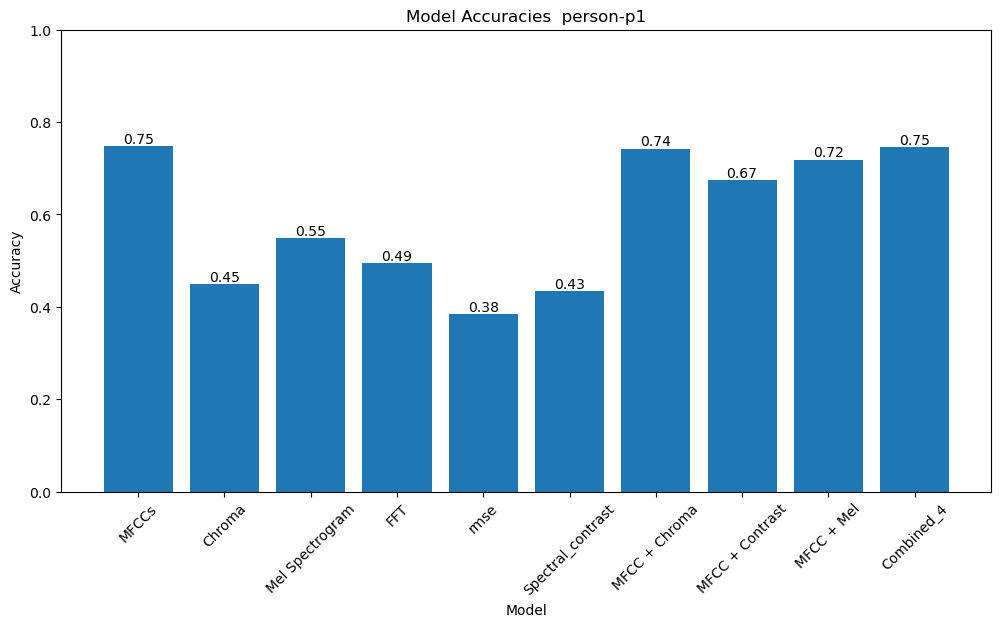

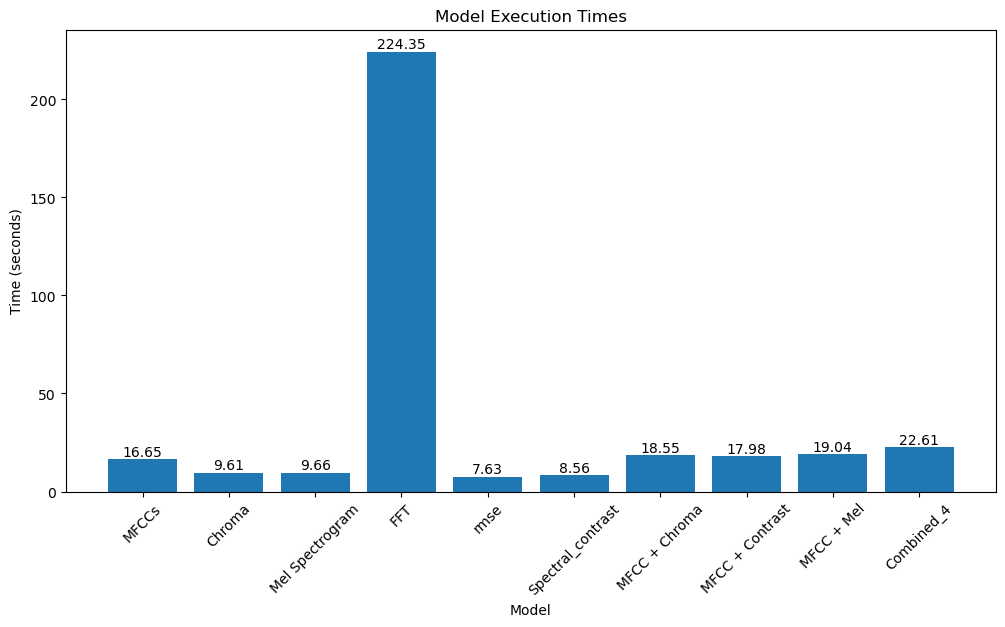

In [74]:

# Plot model accuracies
model_names = [
    "MFCCs", "Chroma", "Mel Spectrogram", "FFT","rmse","Spectral_contrast",
    "MFCC + Chroma", "MFCC + Contrast", "MFCC + Mel","Combined_4"
]

plt.figure(figsize=(12, 6))
bars = plt.bar(model_names, accuracy_stack)
plt.title("Model Accuracies  person-p1")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Annotate each bar with its accuracy value
for bar, accuracy in zip(bars, accuracy_stack):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{accuracy:.2f}', ha='center', va='bottom')

plt.show()
# Plot execution times
plt.figure(figsize=(12, 6))
bar1=plt.bar(model_names, execution_times)
plt.title("Model Execution Times")
plt.xlabel("Model")
plt.ylabel("Time (seconds)")
plt.xticks(rotation=45)
for bar1, time in zip(bar1, execution_times):
    plt.text(bar1.get_x() + bar1.get_width() / 2, bar1.get_height(), f'{time:.2f}', ha='center', va='bottom')

plt.show()
